# Prophet model for energy demand forecasting

This notebook mirrors the LSTM experiment setup and evaluates Prophet on the same forecast horizon.
It loads the preprocessed numpy arrays metadata to keep window size and horizon consistent.

In [12]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import pickle

from sklearn.metrics import mean_absolute_error, root_mean_squared_error

from prophet import Prophet
from sklearn.model_selection import TimeSeriesSplit
import mlflow
from prophet.serialize import model_to_json
from mlflow.models import infer_signature

## Load preprocessed arrays and metadata
The stored window size and forecast horizon are reused so evaluation matches the LSTM setup.


In [2]:
DATA_PATH = Path("../../data/processed")
EXPERIMENT_NAME = "fs_06_load_calendar_future_weather"
OUTPUT_PATH = DATA_PATH / "ml_data" / EXPERIMENT_NAME

# Load numpy arrays (same as LSTM notebook)
scalers_dir = OUTPUT_PATH / "scalers"

X_train_seq = np.load(OUTPUT_PATH / "X_train.npy")
y_train_seq = np.load(OUTPUT_PATH / "y_train.npy")
X_val_seq = np.load(OUTPUT_PATH / "X_val.npy")
y_val_seq = np.load(OUTPUT_PATH / "y_val.npy")
X_test_seq = np.load(OUTPUT_PATH / "X_test.npy")
y_test_seq = np.load(OUTPUT_PATH / "y_test.npy")

with open(scalers_dir / "y_scaler.pkl", "rb") as f:
    y_scaler = pickle.load(f)

with open(OUTPUT_PATH / "meta.json", "r") as f:
    meta = json.load(f)

WINDOW_SIZE = int(meta["window_size"])
FORECAST_HORIZON = int(meta["forecast_horizon"])
FEATURE_NAMES = meta["feature_names"]

print(f"Window size: {WINDOW_SIZE}, Horizon: {FORECAST_HORIZON}")
print(f"Train/Val/Test sequences: {len(y_train_seq)}/{len(y_val_seq)}/{len(y_test_seq)}")


Window size: 672, Horizon: 96
Train/Val/Test sequences: 164214/39863/39863


## First: Start the MLFlow-Server for logging the experiments

Run the following command: 

Powershell:

mlflow server ` 
    --backend-store-uri sqlite:///mlflow.db ` 
    --default-artifact-root ./mlartifacts/  


Bash / Git Bash / WSL / Linux / macOS
mlflow server \
  --backend-store-uri sqlite:///mlflow.db \
  --default-artifact-root ./mlartifacts


In [3]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("load_forecasting_prophet")

<Experiment: artifact_location='file:C:/Users/lhaus/Documents/FH/probabilistic-load-forecast-project/mlartifacts/4', creation_time=1770370936743, experiment_id='4', last_update_time=1770370936743, lifecycle_stage='active', name='load_forecasting_prophet', tags={'mlflow.experimentKind': 'custom_model_development'}>

## Load full dataframe and prepare Prophet input
Prophet expects columns `ds` (timestamp) and `y` (target). Optional regressors are added if available.


In [4]:
# Load the full feature dataframe
df = pd.read_parquet(DATA_PATH / "data_combined.parquet")

TARGET = "actual_load_mw"
regressors = [c for c in FEATURE_NAMES if c != TARGET and c in df.columns]

# Prepare Prophet dataframe
prophet_df = df.copy()
prophet_df = prophet_df.rename(columns={TARGET: "y"})
prophet_df["ds"] = prophet_df.index
prophet_df = prophet_df.reset_index(drop=True)

print(f"Prophet regressors: {len(regressors)}")
prophet_df.head()


Prophet regressors: 6


,y,t2m_future,ssrd_future,tp_future,wind_speed_future,is_weekday,is_holiday,ds
0,5256.0,277.421722,0.0,0.000000e+00,1.758537,True,0,2018-10-01 00:00:00+00:00
1,5204.0,277.421722,0.0,0.000000e+00,1.758537,True,0,2018-10-01 00:15:00+00:00
2,5178.0,277.421722,0.0,0.000000e+00,1.758537,True,0,2018-10-01 00:30:00+00:00
3,5151.0,277.421722,0.0,0.000000e+00,1.758537,True,0,2018-10-01 00:45:00+00:00
4,5187.0,277.252350,0.0,6.201566e-08,1.709355,True,0,2018-10-01 01:00:00+00:00


## Split by saved date ranges
The same train/validation/test date ranges from preprocessing are applied.


In [5]:
# Split using saved metadata date ranges
train_start = pd.to_datetime(meta["train_date_range"]["start"])
train_end = pd.to_datetime(meta["train_date_range"]["end"])
val_start = pd.to_datetime(meta["val_date_range"]["start"])
val_end = pd.to_datetime(meta["val_date_range"]["end"])
test_start = pd.to_datetime(meta["test_date_range"]["start"])
test_end = pd.to_datetime(meta["test_date_range"]["end"])

def slice_by_range(df_in, start, end):
    mask = (df_in["ds"] >= start) & (df_in["ds"] <= end)
    return df_in.loc[mask].copy()

train_df = slice_by_range(prophet_df, train_start, train_end)
val_df = slice_by_range(prophet_df, val_start, val_end)
test_df = slice_by_range(prophet_df, test_start, test_end)

print(f"Train: {train_df.shape}, Val: {val_df.shape}, Test: {test_df.shape}")


Train: (164981, 8), Val: (40630, 8), Test: (40630, 8)


In [6]:
prophet_df["ds"]=prophet_df["ds"].dt.tz_convert(None)
train_df["ds"]=train_df["ds"].dt.tz_convert(None)
val_df["ds"]=val_df["ds"].dt.tz_convert(None)
test_df["ds"]=test_df["ds"].dt.tz_convert(None)

## Model helpers
Define model configuration and helper functions for sequence-style evaluation.


In [ ]:
def build_prophet_model(regressors):
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=True,
    )

    for reg in regressors:
        model.add_regressor(reg)

    return model

def create_sequences_1d(y, window_size, forecast_horizon):
    y = np.asarray(y)
    seq = []
    for i in range(len(y) - window_size - forecast_horizon + 1):
        seq.append(y[i + window_size : i + window_size + forecast_horizon])
    return np.array(seq)

def evaluate_sequences(y_true_seq, y_pred_seq):
    n = min(len(y_true_seq), len(y_pred_seq))
    y_true_seq = y_true_seq[:n]
    y_pred_seq = y_pred_seq[:n]

    mae = mean_absolute_error(y_true_seq, y_pred_seq)
    rmse = root_mean_squared_error(y_true_seq, y_pred_seq)

    print(f"MAE:  {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")

    horizons = [1, 4, 12, 24, 48, 96]
    for h in horizons:
        if h <= y_true_seq.shape[1]:
            h_rmse = root_mean_squared_error(y_true_seq[:, h-1], y_pred_seq[:, h-1])
            print(f"RMSE h{h}: {h_rmse:.3f}")

    return mae, rmse


## Temporal cross-validation with MLflow
TimeSeriesSplit is used on the training data to evaluate multiple folds and log metrics.


In [11]:
N_SPLITS = 5
tscv = TimeSeriesSplit(n_splits=N_SPLITS)

maes = []
rmses = []

rmse_h = {
    1: [],
    4: [],
    12: [],
    24: [],
    48: [],
    96: [],
}

best_rmse = float("inf")
best_model_json = None
best_fold = None

with mlflow.start_run(run_name=f"prophet_tscv_{EXPERIMENT_NAME}"):
    mlflow.log_params({
        "n_splits": N_SPLITS,
        "window_size": WINDOW_SIZE,
        "forecast_horizon": FORECAST_HORIZON,
        "n_regressors": len(regressors),
    })

    for fold, (train_idx, test_idx) in enumerate(tscv.split(prophet_df)):
        with mlflow.start_run(run_name=f"fold_{fold}", nested=True):

            fold_train = prophet_df.iloc[train_idx].copy()
            fold_test= prophet_df.iloc[test_idx].copy()

            model = build_prophet_model(regressors)
            model.fit(fold_train)

            future_test = fold_test.drop(columns=["y"]).copy()
            test_forecast = model.predict(future_test)

            y_test_true = fold_test["y"].values
            y_test_pred = test_forecast["yhat"].values

            y_test_true_seq = create_sequences_1d(y_test_true, WINDOW_SIZE, FORECAST_HORIZON)
            y_test_pred_seq = create_sequences_1d(y_test_pred, WINDOW_SIZE, FORECAST_HORIZON)

            mae = mean_absolute_error(y_test_true_seq, y_test_pred_seq)
            rmse = root_mean_squared_error(y_test_true_seq, y_test_pred_seq)

            maes.append(mae)
            rmses.append(rmse)

            mlflow.log_metric("mae", mae)
            mlflow.log_metric("rmse", rmse)

            horizons = [1, 4, 12, 24, 48, 96]
            for h in horizons:
                if h <= y_test_true_seq.shape[1]:
                    h_rmse = root_mean_squared_error(y_test_true_seq[:, h-1], y_test_pred_seq[:, h-1])
                    mlflow.log_metric(f"rmse_h{h}", h_rmse, step=fold)

                    rmse_h[h].append(h_rmse)
    
    # --- aggregate CV metrics
    mlflow.log_metric("cv_mae_mean", np.mean(maes).item())
    mlflow.log_metric("cv_mae_std", np.std(maes).item())

    mlflow.log_metric("cv_rmse_mean", np.mean(rmses).item())
    mlflow.log_metric("cv_rmse_std", np.std(rmses).item())

    for h in [1, 4, 12, 24, 48, 96]:
        mlflow.log_metric(
            f"cv_rmse_h{h}_mean",
            np.mean(rmse_h[h]).item()
        )
        mlflow.log_metric(
            f"cv_rmse_h{h}_std",
            np.std(rmse_h[h]).item()
        )


10:45:31 - cmdstanpy - INFO - Chain [1] start processing
10:45:56 - cmdstanpy - INFO - Chain [1] done processing


🏃 View run fold_0 at: http://127.0.0.1:5000/#/experiments/4/runs/4a86d6d7550544b0b74ffd6c0800a1f3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/4


10:46:10 - cmdstanpy - INFO - Chain [1] start processing
10:48:01 - cmdstanpy - INFO - Chain [1] done processing


🏃 View run fold_1 at: http://127.0.0.1:5000/#/experiments/4/runs/c20e10fc1d6b43d4b550152bedec1634
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/4


10:48:20 - cmdstanpy - INFO - Chain [1] start processing
10:51:08 - cmdstanpy - INFO - Chain [1] done processing


🏃 View run fold_2 at: http://127.0.0.1:5000/#/experiments/4/runs/ad9afad3e1354c089c08d1a8eaec35b3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/4


10:51:31 - cmdstanpy - INFO - Chain [1] start processing
10:54:56 - cmdstanpy - INFO - Chain [1] done processing


🏃 View run fold_3 at: http://127.0.0.1:5000/#/experiments/4/runs/d24fd6c959524faa8669f2c9c2d281e5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/4


10:55:24 - cmdstanpy - INFO - Chain [1] start processing
10:59:13 - cmdstanpy - INFO - Chain [1] done processing


🏃 View run fold_4 at: http://127.0.0.1:5000/#/experiments/4/runs/c4c36f787ac646e9abb75f76b81bade1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/4
🏃 View run prophet_tscv_fs_06_load_calendar_future_weather at: http://127.0.0.1:5000/#/experiments/4/runs/6c0230795da54a6c9a8986dbf421a7a1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/4


   ## Refit on train+val, evaluate on test
Final fit uses more data, then evaluates on the test period with the same horizon metrics.


In [ ]:
# Refit on train + validation, evaluate on test
train_val_df = pd.concat([train_df, val_df], axis=0, ignore_index=True)

with mlflow.start_run(run_name=f"prophet_final_{EXPERIMENT_NAME}"):
    mlflow.log_params({
        "window_size": WINDOW_SIZE,
        "forecast_horizon": FORECAST_HORIZON,
        "n_regressors": len(regressors),
    })

    model = build_prophet_model(regressors)
    model.fit(train_val_df)

    future_test = test_df.drop(columns=["y"]).copy()
    test_forecast = model.predict(future_test)

    y_test_true = test_df["y"].values
    y_test_pred = test_forecast["yhat"].values

    y_test_true_seq = create_sequences_1d(y_test_true, WINDOW_SIZE, FORECAST_HORIZON)
    y_test_pred_seq = create_sequences_1d(y_test_pred, WINDOW_SIZE, FORECAST_HORIZON)

    print("Test metrics (sequence-based):")
    mae, rmse = evaluate_sequences(y_test_true_seq, y_test_pred_seq)

    mlflow.log_metric("mae", mae)
    mlflow.log_metric("rmse", rmse)

    horizons = [1, 4, 12, 24, 48, 96]
    for h in horizons:
        if h <= y_test_true_seq.shape[1]:
            h_rmse = root_mean_squared_error(y_test_true_seq[:, h-1], y_test_pred_seq[:, h-1])
            mlflow.log_metric(f"rmse_h{h}", h_rmse)


    model_json = model_to_json(model)
    model_dict = json.loads(model_json)

    input_example = future_test.head(96).copy()
    pred_example = model.predict(input_example).copy()  # full Prophet output schema
    signature = infer_signature(input_example, pred_example)

    mlflow.log_dict(meta, "artifacts/data_meta.json")
    # Log model
    mlflow.prophet.log_model(
        pr_model=model,
        name="best_model",
        signature=signature,
        input_example=input_example,
        metadata={
            "feature_set": EXPERIMENT_NAME,
            "window_size": WINDOW_SIZE,
            "forecast_horizon": FORECAST_HORIZON,
            "regressors": regressors,
        },
        params={
            "yearly_seasonality": True,
            "weekly_seasonality": True,
            "daily_seasonality": True
        },
        tags={"feature_set": EXPERIMENT_NAME}
    )

14:07:15 - cmdstanpy - INFO - Chain [1] start processing
14:09:38 - cmdstanpy - INFO - Chain [1] done processing


Test metrics (sequence-based):
MAE:  418.771
RMSE: 521.325
RMSE h1: 521.288
RMSE h4: 521.292
RMSE h12: 521.278
RMSE h24: 521.352
RMSE h48: 521.397
RMSE h96: 521.368


c:\Users\lhaus\Documents\FH\probabilistic-load-forecast-project\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2026/02/10 14:09:46 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/10 14:09:47 INFO mlflow.models.model: Found the following environment variables used during model inference: [CDSAPI_KEY]. Please check if you need to set them when deploying the model. To disable this message, set environment variable `MLFLOW_RECORD_ENV_VARS_IN_MODEL_LOGGING` to `false`.


🏃 View run prophet_final_fs_06_load_calendar_future_weather at: http://127.0.0.1:5000/#/experiments/4/runs/73f7dd056c9c4b38907b476f7bf47615
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/4


## Quick visual check (optional)
Plot a short slice of the test forecast to compare actual vs predicted values.


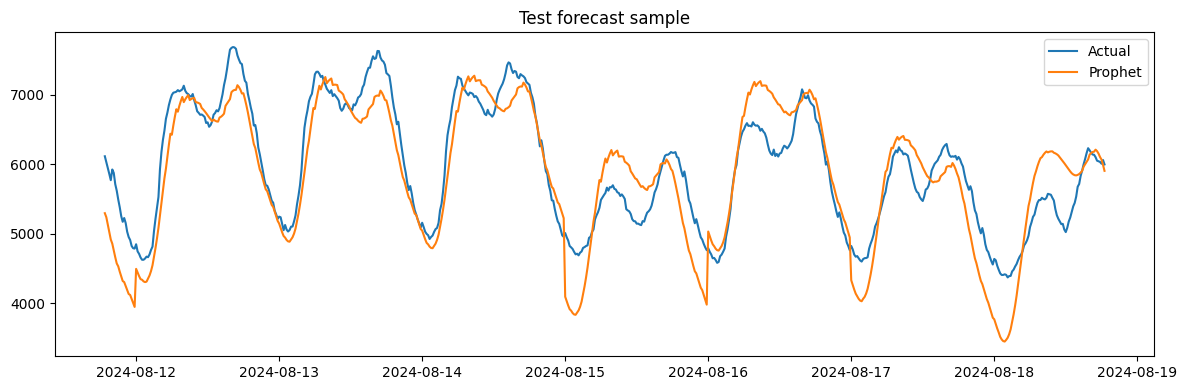

In [18]:
import matplotlib.pyplot as plt

plot_len = 7 * 96  # one week
plot_df = test_df.iloc[:plot_len].copy()
plot_df["yhat"] = test_forecast["yhat"].values[:plot_len]

plt.figure(figsize=(12, 4))
plt.plot(plot_df["ds"], plot_df["y"], label="Actual")
plt.plot(plot_df["ds"], plot_df["yhat"], label="Prophet")
plt.legend()
plt.title("Test forecast sample")
plt.tight_layout()
plt.show()
